## Fitting linear regression via gradient descent

Here, we will see an implementation of gradient descent for a simple linear regression problem, featuring a single weight parameter.  The code will fit a line to a data-set, minimizing total squared error; it will examine the effect of different learning step-size (the $\alpha$ parameter) values upon the regression process.

(Based upon some example code originally written by [Dr. Mike Hughes](https://www.michaelchughes.com).)

In [1]:
# imports and setup
import math
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
np.set_printoptions(suppress=True, precision=2)
pd.set_option('precision', 2) # number precision for pandas
plt.style.use('seaborn') # pretty matplotlib plots

### Create simple dataset:   

We create a simple "linear-like" data-set of 50 points $(x, y)$, $x \in [-2,2]$, $y = 4.2x + \Delta$, where $\Delta$ is some normally-distributed random noise (positive or negative).

In [2]:
def create_dataset(N=100, slope=4.2, noise_stddev=0.1, random_state=0):
    random_state = np.random.RandomState(int(random_state))
    x_N = np.linspace(-2, 2, N)
    y_N = slope * x_N + random_state.randn(N) * noise_stddev
    
    return x_N, y_N

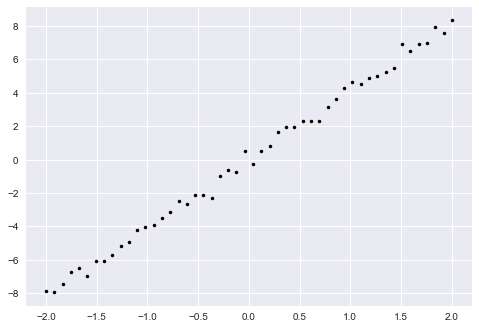

In [3]:
x_N, y_N = create_dataset(N=50, noise_stddev=0.3)

plt.plot(x_N, y_N, 'k.');

### Define loss function and its gradient (derivative)

For our 1-dimensional data points $\{x_1, \ldots, x_n\}$, with ouput values $\{y_1, \ldots y_n\}$, we will define the hypothesis function for our data as a simple application of one weight coefficient: $h(x_i) = w x_i$.  We seek to minimize the sum of squared errors:
$$\mathcal{L} = \sum_{i=1}^n (y_i - h(x_i))^2 = \sum_{i=1}^n (y_i - w x_i)^2$$

The gradient of this function with respect to weight $w$ is the first derivative:
$$\nabla \mathcal{L} = \frac{\partial \mathcal{L}}{\partial w} 
= -2 \sum_{i=1}^n (y_i - w x_i) x_i = 2 \sum_{i=1}^n (w x_i^2 - y_i x_i)$$

We can thus modify the weight $w$ by _subtracting_ the gradient value.  This has the effect that:

1. If the gradient is _positive_ (i.e., we are on the _upward_ slope, _increasing_ the loss function as we move forward), we _decrease_ the weight $w$, moving in the _opposite_ direction.
2. If the gradient is _negative_ (i.e., we are on the _downward_ slope, _decreasing_ the loss function as we move forward), we _increase_ the weight $w$ to move in the _same_ direction as the gradient.

Thus we are doing a process of _**gradient descent**_.

#### A convenient simplification of the mathematics

The goal of gradient descent is to find the weight $w$ that minimizes the error:
$$\arg\min_w \mathcal{L} = \arg\min_w \sum_{i=1}^n (y_i - w x_i)^2$$

What happens if we apply a positive constant $c$ to our loss function?
$$\mathcal{L}^\prime = c \sum_{i=1}^n (y_i - w x_i)^2$$

As it turns out, this makes _no difference_ to the minimization problem, since any $w$ that minimizes $\mathcal{L}^\prime$ also minimizes $\mathcal{L}$:
$$\arg\min_w \mathcal{L}^\prime = \arg\min_w c \sum_{i=1}^n (y_i - w x_i)^2 
= \arg\min_w \sum_{i=1}^n (y_i - w x_i)^2 = \arg\min_w \mathcal{L}$$

Furthermore, the gradient of $\mathcal{L}^\prime$ is simply:
$$\nabla \mathcal{L}^\prime = \frac{\partial \mathcal{L}^\prime}{\partial w} 
= 2 c \sum_{i=1}^n (w x_i^2 - y_i x_i)$$

Using the constant $c = 1/2$, this gives us loss function:
$$\mathcal{L}^\prime = \frac{1}{2} \sum_{i=1}^n (y_i - w x_i)^2$$

And, in turn, this means we can simplify our gradient somewhat (since $2 \cdot 1/2 = 1)$:
$$\nabla \mathcal{L}^\prime = \sum_{i=1}^n (w x_i^2 - y_i x_i)$$

In [4]:
def calculate_loss(w):
    hypothesis_N = x_N * w
    sum_squared_error = 0.5 * np.sum(np.square(y_N - hypothesis_N))
    return sum_squared_error

In [5]:
def calculate_gradient(w):
    gradient = np.sum(w * np.square(x_N) - y_N * x_N)
    return gradient

### Examining our weight-space

We look at 100 different possible weight values $w \in [0, 8]$.

In [6]:
w_grid = np.linspace(0, 8, 100)

#### Examine the loss function and its gradients

We first plot the loss function,  evaluated at each weight value $w$, and then plot the gradient of the function, noting how it goes from negative for $w < 4$, to $0$ for $w = 4$, to positive for $w > 4$.

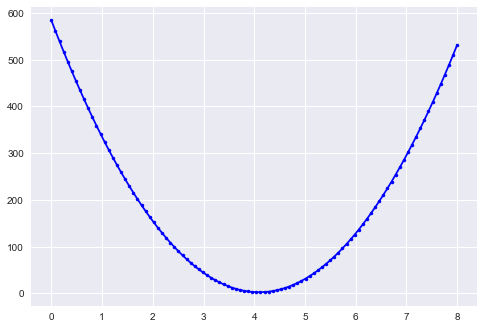

In [7]:
loss_grid = [calculate_loss(w) for w in w_grid]
plt.plot(w_grid, loss_grid, 'b.-')

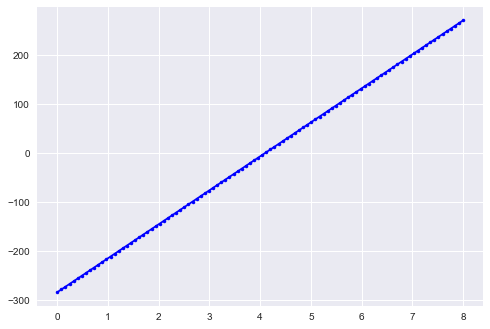

In [8]:
gradient_grid = [calculate_gradient(w) for w in w_grid]
plt.plot(w_grid, gradient_grid, 'b.-')

### Define the gradient descent algorithm

Our function applies a number of iterations of gradient descent, controlled by the `max_iters` parameter.  

At each iteration, the value of the loss function (in its $\mathcal{L}^\prime$ form) is calculated, based upon the data-set given and the current value of weight $w$.  At every iteration _after_ the first, weight $w$ is updated:
$$w \ \leftarrow \ (w - \alpha \nabla \mathcal{L}^\prime) \ = \ (w - \alpha \sum_{i=1}^n (w x_i^2 - y_i x_i))$$

The _step-size parameter_ ($\alpha$) controls the magnitude of the change in the weight; it is controlled by the function parameter `step_size`.  While there is rarely a well-established value for what this parameter _must_ be, a good rule of thumb is to make it some small value, so that adjustements of the wieght in the direction down the gradient are also small.  This helps prevent over-shooting the minimizing value.

In [9]:
def minimize_via_gradient_descent(init_w=0.0, step_size=0.001, max_iters=100):
    w = np.asarray(init_w).copy()
    
    trace_loss = []
    trace_w = []
    trace_gradient = []
    gradient = np.nan
    for iter_id in range(max_iters):
        if iter_id > 0:
            gradient = calculate_gradient(w)    
            w = w - step_size * gradient
        loss = calculate_loss(w)
        
        if iter_id < 10 or (iter_id % 10) == 9:
            print("  iter %5d/%d | loss % 13.4f | w  % 13.5f" % (iter_id, max_iters, loss, w))
    
        trace_loss.append(loss)
        trace_w.append(w)
        trace_gradient.append(gradient)
        
    wopt = w
    return wopt, dict(trace_loss=trace_loss, trace_w=trace_w, trace_gradient=trace_gradient)

### Try with `step_size = 0.0001`

In [10]:
wopt, info_dict = minimize_via_gradient_descent(step_size=0.0001);

  iter     0/100 | loss      584.0407 | w        0.00000
  iter     1/100 | loss      575.9984 | w        0.02841
  iter     2/100 | loss      568.0674 | w        0.05662
  iter     3/100 | loss      560.2460 | w        0.08463
  iter     4/100 | loss      552.5328 | w        0.11246
  iter     5/100 | loss      544.9262 | w        0.14008
  iter     6/100 | loss      537.4249 | w        0.16752
  iter     7/100 | loss      530.0273 | w        0.19477
  iter     8/100 | loss      522.7320 | w        0.22182
  iter     9/100 | loss      515.5376 | w        0.24869
  iter    19/100 | loss      448.8447 | w        0.50734
  iter    29/100 | loss      390.8218 | w        0.74859
  iter    39/100 | loss      340.3417 | w        0.97361
  iter    49/100 | loss      296.4239 | w        1.18350
  iter    59/100 | loss      258.2152 | w        1.37927
  iter    69/100 | loss      224.9737 | w        1.56188
  iter    79/100 | loss      196.0534 | w        1.73220
  iter    89/100 | loss      17

(0.0, 100.0)

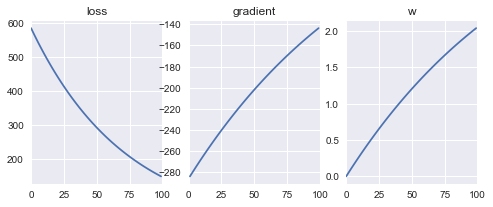

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(8,3))

axes[0].plot(info_dict['trace_loss']);
axes[0].set_title('loss');
axes[1].plot(info_dict['trace_gradient']);
axes[1].set_title('gradient');
axes[2].plot(info_dict['trace_w']);
axes[2].set_title('w');

plt.xlim([0, 100])

With `step_size = 0.0001`, gradient descent progresses very smoothly, but doesn't make enough progress.  The loss gradually decreases and starts to flatten a bit $\approx$ 149, but is still far from 0.  The algorithm smoothly descends the gradient, with the weight increasing from its intial value (0) to a final value $\approx$ 2.  We are not yet at the minimal point ($w \approx$ 4) because the small value of the step-size parameter means we are too cautious.  

To solve this, we either need to increase the number of iterations (`max_iters`) of weight adjustment, or (as we will do next), increase `step_size` to make larger updates in each iteration.

### Try with `step_size = 0.001`

In [12]:
wopt, info_dict = minimize_via_gradient_descent(step_size=0.001);

  iter     0/100 | loss      584.0407 | w        0.00000
  iter     1/100 | loss      506.1378 | w        0.28408
  iter     2/100 | loss      438.6709 | w        0.54845
  iter     3/100 | loss      380.2418 | w        0.79448
  iter     4/100 | loss      329.6400 | w        1.02343
  iter     5/100 | loss      285.8168 | w        1.23650
  iter     6/100 | loss      247.8643 | w        1.43479
  iter     7/100 | loss      214.9958 | w        1.61931
  iter     8/100 | loss      186.5305 | w        1.79103
  iter     9/100 | loss      161.8784 | w        1.95084
  iter    19/100 | loss       40.3317 | w        3.04997
  iter    29/100 | loss       11.4836 | w        3.58544
  iter    39/100 | loss        4.6367 | w        3.84630
  iter    49/100 | loss        3.0116 | w        3.97339
  iter    59/100 | loss        2.6259 | w        4.03531
  iter    69/100 | loss        2.5344 | w        4.06547
  iter    79/100 | loss        2.5126 | w        4.08017
  iter    89/100 | loss        

(0.0, 100.0)

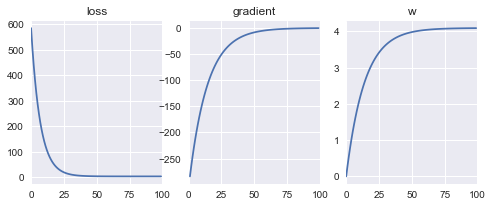

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(8,3))

axes[0].plot(info_dict['trace_loss']);
axes[0].set_title('loss');
axes[1].plot(info_dict['trace_gradient']);
axes[1].set_title('gradient');
axes[2].plot(info_dict['trace_w']);
axes[2].set_title('w');

plt.xlim([0, 100])

With a 10-fold increase in the learning rate (`step_size = 0.001`), gradient descent progresses very smoothly and _does_ find a near-optimal value for the weight.  The loss gradually decreases and plateaus near 0 (it is never exactly 0, since our data is not strictly on a line).  The algorithm smoothly descends the gradient to where it bottoms out, with the weight increasing from its intial value (0) to a final value $\approx$ 4.

Now, let's see if we can get this result even faster, by increasing the learning rate again.

### Try with `step_size = 0.02`

In [14]:
wopt, info_dict = minimize_via_gradient_descent(step_size=0.02);

  iter     0/100 | loss      584.0407 | w        0.00000
  iter     1/100 | loss       89.9420 | w        5.68165
  iter     2/100 | loss       15.6522 | w        3.47856
  iter     3/100 | loss        4.4825 | w        4.33282
  iter     4/100 | loss        2.8031 | w        4.00158
  iter     5/100 | loss        2.5506 | w        4.13002
  iter     6/100 | loss        2.5126 | w        4.08021
  iter     7/100 | loss        2.5069 | w        4.09952
  iter     8/100 | loss        2.5060 | w        4.09204
  iter     9/100 | loss        2.5059 | w        4.09494
  iter    19/100 | loss        2.5059 | w        4.09413
  iter    29/100 | loss        2.5059 | w        4.09413
  iter    39/100 | loss        2.5059 | w        4.09413
  iter    49/100 | loss        2.5059 | w        4.09413
  iter    59/100 | loss        2.5059 | w        4.09413
  iter    69/100 | loss        2.5059 | w        4.09413
  iter    79/100 | loss        2.5059 | w        4.09413
  iter    89/100 | loss        

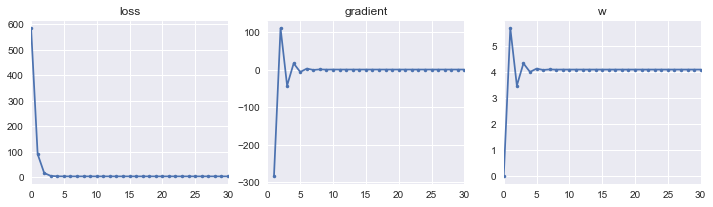

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(12,3))

axes[0].plot(info_dict['trace_loss'], '.-');
axes[0].set_title('loss');
axes[1].plot(info_dict['trace_gradient'], '.-');
axes[1].set_title('gradient');
axes[2].plot(info_dict['trace_w'], '.-');
axes[2].set_title('w');

plt.xlim([0, 30]);

With `step_size = 0.02`, gradient descent progresses in a less-smooth fashion.  The loss decreases more quickly, due to larger changes in the weight value, which means the algorithm actually learns faster, and could get by with even fewer iterations overall.  At the same time, the weight "over-shoots" the low point in the gradient, _ascending_ and _increasing_ the weight (to $\approx$ 5.7), going back below 4 again (to $\approx$ 3.5), and continuing the back and forth before converging around a final value, again $\approx$ 4.

Can we do even better, learning more efficiently with an even larger step-size value?

### Try with `step_size = 0.5`

In [16]:
wopt, info_dict = minimize_via_gradient_descent(step_size=0.5);

  iter     0/100 | loss      584.0407 | w        0.00000
  iter     1/100 | loss   660205.8611 | w      142.04119
  iter     2/100 | loss  749513940.7965 | w    -4643.87715
  iter     3/100 | loss  850906223453.7733 | w   156612.26939
  iter     4/100 | loss  966014591749143.7500 | w  -5276732.58657
  iter     5/100 | loss  1096694519035568512.0000 | w   177793723.68271
  iter     6/100 | loss  1245052485081911787520.0000 | w  -5990559813.06397
  iter     7/100 | loss  1413479928733343976259584.0000 | w   201845188945.48215
  iter     8/100 | loss  1604691796427019971599532032.0000 | w  -6800947080449.61035
  iter     9/100 | loss  1821770305452964841320496496640.0000 | w   229150278159780.93750
  iter    19/100 | loss  6479082105853981388580298981748662874210512544077059647864832.0000 | w   432145824507562065874013650944.00000
  iter    29/100 | loss  23042699076138304762147348066273145967431978355944824780072020598141309600337976771934683136.0000 | w   8149674315870027512558720805735

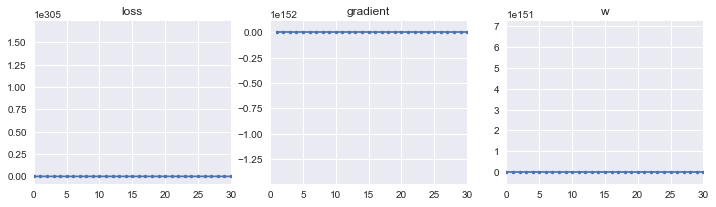

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(12,3))

axes[0].plot(info_dict['trace_loss'], '.-');
axes[0].set_title('loss');
axes[1].plot(info_dict['trace_gradient'], '.-');
axes[1].set_title('gradient');
axes[2].plot(info_dict['trace_w'], '.-');
axes[2].set_title('w');

plt.xlim([0, 30]);

With the larger step-size, we get _degenerate_ results: the weight changes _too much_ based upon the gradient, and ends up with values from which it cannot recover.  Loss grows uncontrollably, as the weight swings between very large and very small values on each iteration, without any convergence at all.

**Note**: the plots here are basically meaningless, as the values are out of range for sensible plotting.